In [57]:
# Import all relevant dependencies
import torch, json
from torch import nn, optim
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Reference the right data directory for train and validation respectively
data_dir = './flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [18]:
# Perform data augmentation as well as normalize and standardize the images based on the ImageNet Means and Standard Deviations

train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(0.7),
                                       transforms.RandomRotation(30),
                                       transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# Just to check what class_to_idx does on the datasets.ImageFolder variable
print(valid_data.class_to_idx)

{'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '11': 5, '12': 6, '13': 7, '14': 8, '15': 9, '16': 10, '17': 11, '18': 12, '19': 13, '2': 14, '20': 15, '21': 16, '22': 17, '23': 18, '24': 19, '25': 20, '26': 21, '27': 22, '28': 23, '29': 24, '3': 25, '30': 26, '31': 27, '32': 28, '33': 29, '34': 30, '35': 31, '36': 32, '37': 33, '38': 34, '39': 35, '4': 36, '40': 37, '41': 38, '42': 39, '43': 40, '44': 41, '45': 42, '46': 43, '47': 44, '48': 45, '49': 46, '5': 47, '50': 48, '51': 49, '52': 50, '53': 51, '54': 52, '55': 53, '56': 54, '57': 55, '58': 56, '59': 57, '6': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '7': 69, '70': 70, '71': 71, '72': 72, '73': 73, '74': 74, '75': 75, '76': 76, '77': 77, '78': 78, '79': 79, '8': 80, '80': 81, '81': 82, '82': 83, '83': 84, '84': 85, '85': 86, '86': 87, '87': 88, '88': 89, '89': 90, '9': 91, '90': 92, '91': 93, '92': 94, '93': 95, '94': 96, '95': 97, '96': 98, '97': 99, '98': 100, '99'

In [19]:
# Initialize train and validation DataLoader with batch size = 32

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)


print(len(trainloader)) # Number of batches
print(len(trainloader.dataset)) # Number of training examples

205
6552


In [20]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [21]:
# Define the model, pretrained ResNet18
model = models.resnet18(pretrained=True)

In [22]:
drop_prob = 0.5

# Freeze all the parameters of the model i.e. Backpropogation will not affect those parameters
for param in model.parameters():
    param.requires_grad = False
    
from collections import OrderedDict

# Define a new fully connected layer to suit the task at hand i.e. 102 different classes of flowers
fully_connected = nn.Sequential(OrderedDict([
                                            ('fc1', nn.Linear(512,102)),
                                            ('output', nn.LogSoftmax(dim=1))
                                            ]))

model.fc = fully_connected
model.fc

Sequential(
  (fc1): Linear(in_features=512, out_features=102, bias=True)
  (output): LogSoftmax()
)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, last_epoch=-1)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [9]:
epochs = 30

valid_loss_min = np.Inf

plot_train = []
plot_valid = []


for epoch in range(epochs):
    model.to(device)
    train_loss = 0
    valid_loss = 0
    accuracy = 0
    
    # scheduler.step()
    ### Train the model on the training set ###
    model.train()
    for images, labels in trainloader:
        # Bring the images and labels to respective device
        images, labels = images.to(device), labels.to(device)
        
        # Zero out accumulated gradients
        optimizer.zero_grad()
        
        # Forward and Backward Pass using LogSoftmax and NLLLoss
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        
        # Update the weights and biases
        optimizer.step()
        
        train_loss += loss.item()*images.size(0) # calculate for entire batch loss (adding every batch loss value)
        
    ### Evaluate the model on the validation set ###
    model.eval() # Sets dropout and batch normalization to "Off"
    ### Set the requires_grad parameter to false as we do not need gradients to be computed. Speeds up computation ###
    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)

            logps = model(images)
            loss = criterion(logps, labels)
            
            valid_loss += loss.item()*images.size(0)
            
            # Calculate the accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
    

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.3f}%'.format(
        epoch+1, train_loss/len(trainloader.dataset), valid_loss/len(validloader.dataset), (accuracy/len(validloader)) * 100))
    
    # Saving training and validation loss to a list for plotting with Matplotlib
    plot_train.append(train_loss/len(trainloader.dataset))
    plot_valid.append(valid_loss/len(validloader.dataset))
    

    model.to('cpu')
    model.class_to_idx = valid_data.class_to_idx
    checkpoint = {'model': model,
                  'dropout': drop_prob,
                 'criterion': criterion,
                 'image_size': 224,
                 'state_dict': model.state_dict()}
    
    # Performing early stopping, as long as model validation is decreasing, save it, else do not save
    if valid_loss <= valid_loss_min:
        print('Validation Loss Decreased ({:.6f} -----------> {:.6f}). Saving model ...'.format(
            valid_loss_min/len(validloader.dataset),
            valid_loss/len(validloader.dataset)))
        torch.save(checkpoint, 'resnet18_flower_test.pth')
        valid_loss_min = valid_loss
        

Epoch: 1 	Training Loss: 2.616928 	Validation Loss: 1.151792 	Validation Accuracy: 82.599%
Validation Loss Decreased (inf -----------> 1.151792). Saving model ...
Epoch: 2 	Training Loss: 0.914727 	Validation Loss: 0.595914 	Validation Accuracy: 90.411%
Validation Loss Decreased (1.151792 -----------> 0.595914). Saving model ...
Epoch: 3 	Training Loss: 0.560935 	Validation Loss: 0.454749 	Validation Accuracy: 91.373%
Validation Loss Decreased (0.595914 -----------> 0.454749). Saving model ...
Epoch: 4 	Training Loss: 0.421876 	Validation Loss: 0.358306 	Validation Accuracy: 93.536%
Validation Loss Decreased (0.454749 -----------> 0.358306). Saving model ...
Epoch: 5 	Training Loss: 0.340486 	Validation Loss: 0.317338 	Validation Accuracy: 93.897%
Validation Loss Decreased (0.358306 -----------> 0.317338). Saving model ...
Epoch: 6 	Training Loss: 0.284128 	Validation Loss: 0.313052 	Validation Accuracy: 93.056%
Validation Loss Decreased (0.317338 -----------> 0.313052). Saving model .

KeyboardInterrupt: 

In [23]:
drop_prob = 0.5

# Define my classifier
class Classifier(nn.Module):

    def __init__(self, in_features=512, hidden_features=256, 
                       out_features=102, drop_prob=drop_prob):
        super().__init__()

        self.fc1 = nn.Linear(in_features, out_features)
        #self.fc2 = nn.Linear(hidden_features, out_features)
        #self.drop = nn.Dropout(p=drop_prob)

    def forward(self, x):
        #x = self.drop(F.relu(self.fc1(x)))
        x = self.fc1(x)
        x = F.log_softmax(x, dim=1)
        return x


def load_checkpoint(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)

    model = models.resnet18(pretrained=False)
#     for param in model.parameters():
#         param.requires_grad = False

    # Put the classifier on the pretrained network
    model.fc = Classifier()

    model.load_state_dict(checkpoint['state_dict'])

    return model

In [24]:
model = load_checkpoint('./resnet18_flower_v7.1.0_best.pth') # Latest 97.716 with no lr scheduler and lr of 0.00005 and achieved 98.438 with no lr scheduler lr of 0.000025

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000025)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5, last_epoch=-1)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [13]:
epochs = 30

valid_loss_min = np.Inf

plot_train = []
plot_valid = []


for epoch in range(epochs):
    model.to(device)
    train_loss = 0
    valid_loss = 0
    accuracy = 0
    ### Train the model on the training set ###
    model.train()
#     scheduler.step()
    for images, labels in trainloader:
        # Bring the images and labels to respective device
        images, labels = images.to(device), labels.to(device)
        
        # Zero out accumulated gradients
        optimizer.zero_grad()
        
        # Forward and Backward Pass using LogSoftmax and NLLLoss
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        
        # Update the weights and biases
        optimizer.step()
        
        train_loss += loss.item()*images.size(0) # calculate for entire batch loss
        
    ### Evaluate the model on the validation set ###
    model.eval()
    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)

            logps = model(images)
            loss = criterion(logps, labels)
            
            valid_loss += loss.item()*images.size(0)
            
            # Calculate the accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
   
    '''accuracy contains sum of the mini batches averaged accuracy to calculate the accuracy on the entire dataset, further divide
    by using the length of the validation loader'''
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.3f}%'.format(
        epoch+1, train_loss/len(trainloader.dataset), valid_loss/len(validloader.dataset), (accuracy/len(validloader)) * 100))
    
    
    plot_train.append(train_loss/len(trainloader))
    plot_valid.append(valid_loss/len(validloader))
    

    model.to('cpu')
    model.class_to_idx = valid_data.class_to_idx
    checkpoint = {'model': model,
                  'dropout': drop_prob,
                 'criterion': criterion,
                 'image_size': 224,
                 'state_dict': model.state_dict()}
    
    if valid_loss <= valid_loss_min:
        print('Validation Loss Decreased ({:.6f} -----------> {:.6f}). Saving model ...'.format(
            valid_loss_min/len(validloader.dataset),
            valid_loss/len(validloader.dataset)))
        torch.save(checkpoint, 'resnet18_flower_test.pth') 
        valid_loss_min = valid_loss
        

Epoch: 1 	Training Loss: 0.002889 	Validation Loss: 0.094205 	Validation Accuracy: 98.077%
Validation Loss Decreased (inf -----------> 0.094205). Saving model ...


C:\Users\Clement-PC\AppData\Local\Programs\Python\Python36\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Classifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2 	Training Loss: 0.001678 	Validation Loss: 0.091107 	Validation Accuracy: 98.197%
Validation Loss Decreased (0.094205 -----------> 0.091107). Saving model ...
Epoch: 3 	Training Loss: 0.001242 	Validation Loss: 0.084258 	Validation Accuracy: 97.957%
Validation Loss Decreased (0.091107 -----------> 0.084258). Saving model ...
Epoch: 4 	Training Loss: 0.000921 	Validation Loss: 0.084316 	Validation Accuracy: 98.438%
Epoch: 5 	Training Loss: 0.001000 	Validation Loss: 0.083175 	Validation Accuracy: 98.558%
Validation Loss Decreased (0.084258 -----------> 0.083175). Saving model ...
Epoch: 6 	Training Loss: 0.001600 	Validation Loss: 0.091760 	Validation Accuracy: 97.716%


KeyboardInterrupt: 

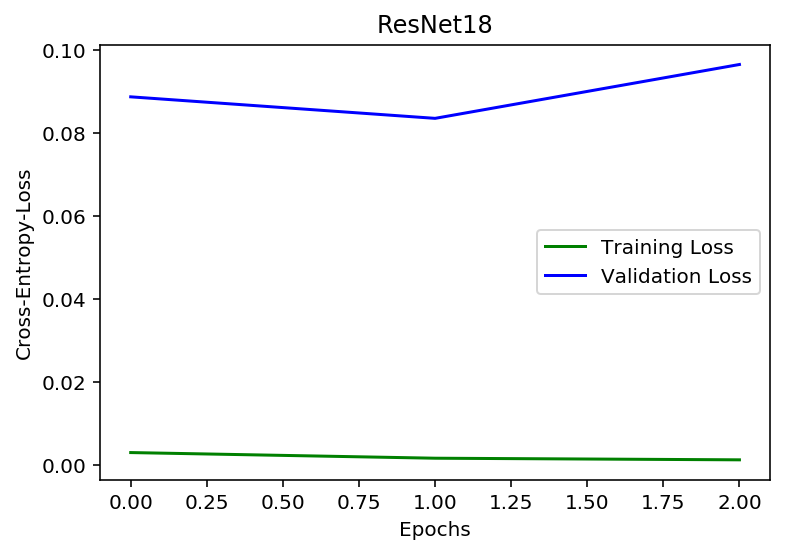

In [14]:
plt.figure(1)

# print(plot_train)
# print(plot_valid)

plt.plot(range(3), plot_train, 'g', label="Training Loss")
plt.plot(range(3), plot_valid, 'b', label="Validation Loss")
plt.title('ResNet18')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy-Loss')
plt.legend()

In [50]:
from PIL import Image

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    img = Image.open(image)
    
    # Resize the image to 256 x 256 keeping it's aspect ratio can use thumbnail or resize function
    if img.size[0] > img.size[1]: 
        img.thumbnail((1000000, 256))
    else:
        img.thumbnail((256, 20000000000))
    
                      
    # img.size returns w,h respectively in PIL
    left = (img.width-224)/2 
    top = (img.height-224)/2
    right = left + 224
    bottom = top + 224
    
                      
    # Crop takes in (left, upper, right, lower) portion of the images
    img = img.crop((left, top, right,    
                   bottom))
                      
    img = np.array(img)/255         
    
    
    # Normalize the image based on the pre-trained model's mean and std
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # PyTorch accepts the tensor as Cin x Height x Width, PIL image format = Width x Height x Cin
    img = img.transpose((2, 0, 1))  
         
    return img

In [51]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    
    image = image.transpose((1, 2, 0))
    # print(image.shape)
    
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

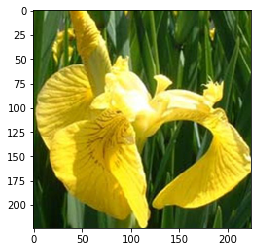

In [65]:
image_path = './flower_data/valid/15/image_06346.jpg'
img = process_image(image_path)
imshow(img)

In [66]:
def predict(image_path, model, topk=5):
    ''' 
    Predict the class (or classes) of an image using a trained deep learning model.
    '''
    model.eval()
    
    # Preprocess and prepare the image such that it is in a compatible format
    img = process_image(image_path)
    img = torch.from_numpy(img).type(torch.FloatTensor)
    img = img.unsqueeze(0)
    
    
    logps = model(img)
    probs = torch.exp(logps)
    top_probs, top_labs = probs.topk(5) # get the top 5 results returns probabilities as well as the indices (values, indices)
    
    
    top_probs = top_probs.detach().numpy().tolist()[0] # Access first index to get all 5 elements as it is a nested list
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    model.class_to_idx = valid_data.class_to_idx
    idx_to_class = {val: key for key, val in (model.class_to_idx).items()}
    
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    
    
    return top_probs, top_labels, top_flowers


In [67]:
model = load_checkpoint('./resnet18_flower_v7.1.0_best.pth')
predict(image_path , model)

([0.9999761581420898,
  2.151368244085461e-05,
  9.068108397514152e-07,
  3.368730574493384e-07,
  2.64594802956708e-07],
 ['15', '77', '90', '101', '68'],
 ['yellow iris',
  'passion flower',
  'canna lily',
  'trumpet creeper',
  'bearded iris'])

In [68]:
def plot_solution(image_path, model):
    # Set up plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[3]
    title_ = cat_to_name[flower_num]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()

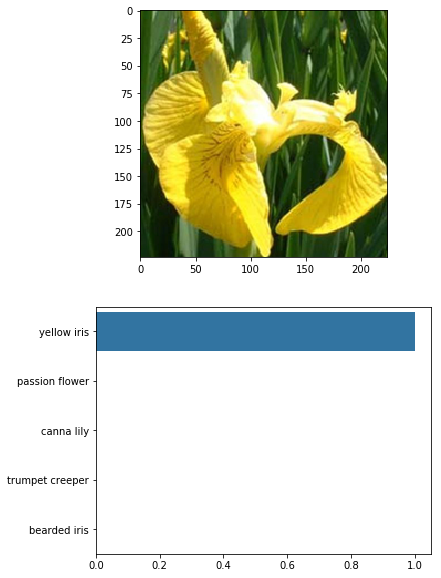

In [69]:
plot_solution(image_path, model)